# First model attempt

https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

In [1]:
import sys
sys.path.insert(1, '/Users/lauradellantonio/neuefische/Capstone/capstone')

In [2]:
import pandas as pd
import numpy as np

import functions.functions_data
import functions.functions_mask_wearing
import functions.functions_corona_stats
import functions.functions_HDI
import functions.functions_mask_req

pd.set_option('display.max_columns', None) # To display all columns

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

## Reading in and adjusting data

In [3]:
# Reading in survey data and joining it into one dataframe
dfs_country = functions.functions_data.get_data("/Users/lauradellantonio/neuefische/Capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")
countries = pd.concat(dfs_country, ignore_index=True)

Read in data completed.


In [4]:
# Adding the real COVID numbers to the dataframe
covid_cases = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/Corona_stats/owid-covid-data.csv")
countries = functions.functions_corona_stats.merge_corona_stats(countries,covid_cases)

Merging corona stats completed.


In [5]:
# Sorting out the date column within the dataframe
countries = functions.functions_data.insert_month(countries)

Created month column.


In [6]:
# Dealing with the NaN in the mask wearing column
countries = functions.functions_mask_wearing.deal_with_NaNs_masks(countries)

NaNs before update: 163383
NaNs after update: 0
Updated.


In [7]:
# Getting the dictionaries for the hdi and the hdi-levels.
dict_hdi, dict_hdi_levels = functions.functions_HDI.get_hdi("/Users/lauradellantonio/neuefische/Capstone/capstone/data","hdro_statistical_data_tables_1_15_d1_d5.xlsx")

# Creating a new column with the hdi and the hdi-levels in the regions dataframe
countries = functions.functions_HDI.create_hdi_columns(countries, dict_hdi, dict_hdi_levels)

Creating dictionaries for hdi and hdi-levels completed.
Creating hdi list completed.
Creating hdi-level list completed.


In [8]:
# Adding the mask wearing requirements to the dataframe
mask_wearing_requirements = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/data-nbhtq.csv")
countries = functions.functions_mask_req.merge_mask_requirements(countries,mask_wearing_requirements)
countries = functions.functions_mask_req.add_requirement_by_date(countries)

Merging mask wearing requirements completed.
Feature engineering completed.


## Selecting relevant columns

In [9]:
df = countries.copy()

In [10]:
# Date used as index

In [11]:
df = df[df["age_bucket"]=="overall"]
df = df[df["gender"]=="overall"]

In [12]:
date = ["date"]

columns_general = ["iso_code", "hdi", "median_age", "aged_65_older", "total_cases_per_million", "new_cases_smoothed_per_million",
                   "total_deaths_per_million", "new_deaths_smoothed_per_million"]

columns_social_distancing = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_spent_time_with_non_hh_weighted", "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted"]

columns_mask_wearing = ["smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted", "smoothed_pct_wear_mask_half_time_weighted", 
                        "smoothed_pct_wear_mask_some_time_weighted","smoothed_pct_wear_mask_none_time_weighted"]

columns_mask_req = ["cur_mask_recommended", "cur_mask_required_full_country", "cur_mask_not_required", "cur_mask_not_required_recommended", "cur_mask_not_required_universal", 
                    "cur_mask_required_part_country", "cur_mask_everywhere_in_public", "cur_mask_public_indoors", "cur_mask_public_transport"]

columns_interest = date + columns_general + columns_social_distancing + columns_mask_wearing + columns_mask_req

In [13]:
df_select = df[columns_interest]

In [14]:
df_select.set_index("date", inplace=True)

In [15]:
df_deu = df_select[df_select["iso_code"]=="DEU"]

In [16]:
df_deu.drop("iso_code", axis=1, inplace=True)

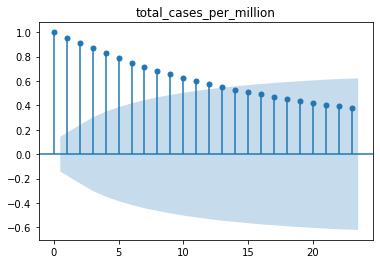

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_deu['total_cases_per_million'])
plt.title('total_cases_per_million')

plt.show()

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johan_test = df_deu
coint_johansen(johan_test,-1,1).eig

/Users/lauradellantonio/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


LinAlgError: Singular matrix

In [19]:
#scale the values
df_deu_values = df_deu.values
scaler = MinMaxScaler(feature_range=(0, 1))
df_deu_scaled = scaler.fit_transform(df_deu_values)

In [23]:
df_deu_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:


#divide the data into train and test data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#index the data into dependent and independent variables
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)